In [130]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

In [240]:
# Constants
gbar_K = 36
gbar_Na = 120
g_L = 0.3
E_K = -12
E_Na = 115
E_L = 10.6
C = 1

<div>
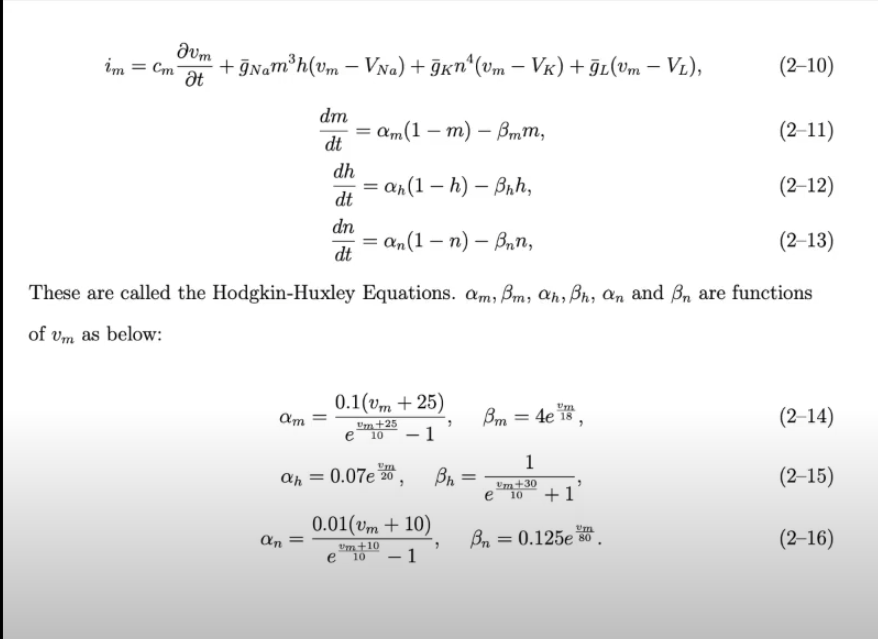
</div>

# The main simulation function
### Arguments:
<b>total_duration:</b> The number of milliseconds the simulation should run <br>
<b>delta_t:</b> The gap (in milliseconds) between two simulation points <br>
<b>I:</b> A list of current values being applied. The length of this list MUST be equal to (total_duation/delta_t) <br>
<b>resting_V:</b> The resting potential <br>

In [262]:
def simulate_V(total_duration = 100, delta_t = 0.01, I = [3]*10000, resting_V = -70):
    
    # The list with all time points
    t = [i*delta_t for i in range(int(total_duration/delta_t))]
    
    # Initializing all the values at t = 0
    V = np.zeros(len(t))
    alpha_m = 0.1 * (V + 25) / (np.exp((V + 25) / 10) - 1)
    beta_m = 4 * np.exp(V / 18)
    alpha_h = 0.07 * np.exp(V / 20)
    beta_h = 1 / (np.exp((V + 30) / 10) + 1)
    alpha_n = 0.01 * (V + 10) / (np.exp((V + 10) / 10) - 1)
    beta_n = 0.125 * np.exp(V / 80)

    n = m = h = np.zeros(len(t))
    n = alpha_n / (alpha_n + beta_n)
    m = alpha_m / (alpha_m + beta_m)
    h = alpha_h / (alpha_h + beta_h)

    # Calculate V at each time step
    for i in range(len(t) - 1):
        
        # Coefficients
        alpha_m[i] = 0.1 * (-V[i] + 25) / (np.exp((-V[i] + 25) / 10) - 1)
        beta_m[i] = 4 * np.exp(-V[i] / 18)
        alpha_h[i] = 0.07 * np.exp(-V[i] / 20)
        beta_h[i] = 1 / (np.exp((-V[i] + 30) / 10) + 1)
        alpha_n[i] = 0.01 * (-V[i] + 10) / (np.exp((-V[i] + 10) / 10) - 1)
        beta_n[i] = 0.125 * np.exp(-V[i] / 80)
        
        # Currents
        I_Na = m[i]**3 * gbar_Na * h[i] * (V[i] - E_Na)
        I_K = n[i]**4 * gbar_K * (V[i] - E_K)
        I_L = g_L * (V[i] - E_L)
        I_ion = I[i] - I_K - I_Na - I_L
        
        # Knowing the functions' current values and derivatives, calculating the next function values.
        V[i+1] = V[i] + delta_t * I_ion / C
        m[i+1] = m[i] + delta_t * (alpha_m[i] * (1 - m[i]) - beta_m[i] * m[i])
        h[i+1] = h[i] + delta_t * (alpha_h[i] * (1 - h[i]) - beta_h[i] * h[i])
        n[i+1] = n[i] + delta_t * (alpha_n[i] * (1 - n[i]) - beta_n[i] * n[i])

    V = V + resting_V
    return t, V

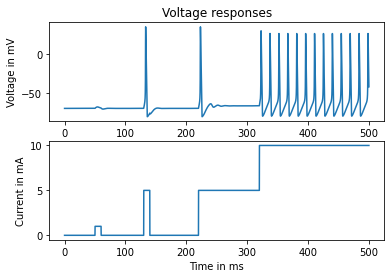

In [398]:
I1 = [0]*5000 + [1]*1000 + [0]*7000 + [5]*1000 + [0]*1000 + [0]*7000 + [5]*10000 + [10]*18000
t1, V1 = simulate_V(total_duration = 500, delta_t = 0.01, I = I1, resting_V = -70)

fig, axs = plt.subplots(2)
axs[0].plot(t1, V1)
axs[0].set(ylabel='Voltage in mV')
axs[1].plot(t1, I1)
axs[1].set(xlabel='Time in ms', ylabel='Current in mA')
axs[0].title.set_text('Voltage responses')

### Estimating rheobase

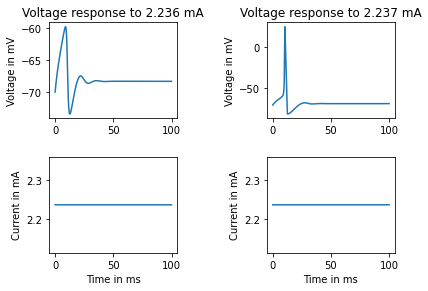

In [355]:
# I figured out 2.237 manually by analyzing at which point the neurons activates
I1 = [2.236]*10000
t1, V1 = simulate_V(total_duration = 100, delta_t = 0.01, I = I1, resting_V = -70)

I2 = [2.237]*10000
t2, V2 = simulate_V(total_duration = 100, delta_t = 0.01, I = I2, resting_V = -70)

fig, axs = plt.subplots(2,2)
axs[0][0].plot(t1, V1)
axs[0][0].set(ylabel='Voltage in mV')
axs[1][0].plot(t1, I1)
axs[1][0].set(xlabel='Time in ms', ylabel='Current in mA')
axs[0][0].title.set_text('Voltage response to 2.236 mA')

axs[0][1].plot(t2, V2)
axs[0][1].set(ylabel='Voltage in mV')
axs[1][1].plot(t2, I2)
axs[1][1].set(xlabel='Time in ms', ylabel='Current in mA')
axs[0][1].title.set_text('Voltage response to 2.237 mA')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.4)

### Plotting f-I curve

In [356]:
currents = list(np.linspace(-10, 15, 25))
spike_freqs = []
for c in currents:
    
    t, V = simulate_V(
        total_duration = 1000,
        delta_t = 0.05,
        I = [c] * 20000,
        resting_V = -70
    )
    
    increasing = True
    peaks = 0
    
    if c >= 2.237:
        for i, v in enumerate(V[1:-1], 1):
            if V[i-1] < v and v > V[i+1]:
                peaks += 1

        spike_freqs.append(peaks)
    else:
        spike_freqs.append(0)

Text(0.5, 1.0, 'f-I curve')

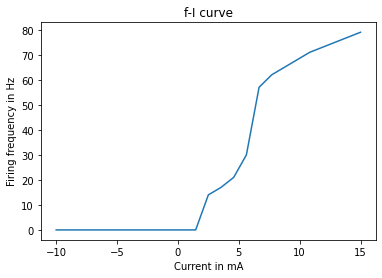

In [357]:
plt.plot(currents, np.array(spike_freqs))
plt.xlabel('Current in mA')
plt.ylabel('Firing frequency in Hz')
plt.title('f-I curve')